In [35]:
try:
  import easyocr
except:
  !pip install easyocr
  import easyocr
  
reader = easyocr.Reader(['pl'])

In [55]:
import pandas as pd
import re

In [60]:
from google.colab import files
import io
uploaded = files.upload()

Saving 2022.09.06_24001908120220906698299.jpg.png to 2022.09.06_24001908120220906698299.jpg.png


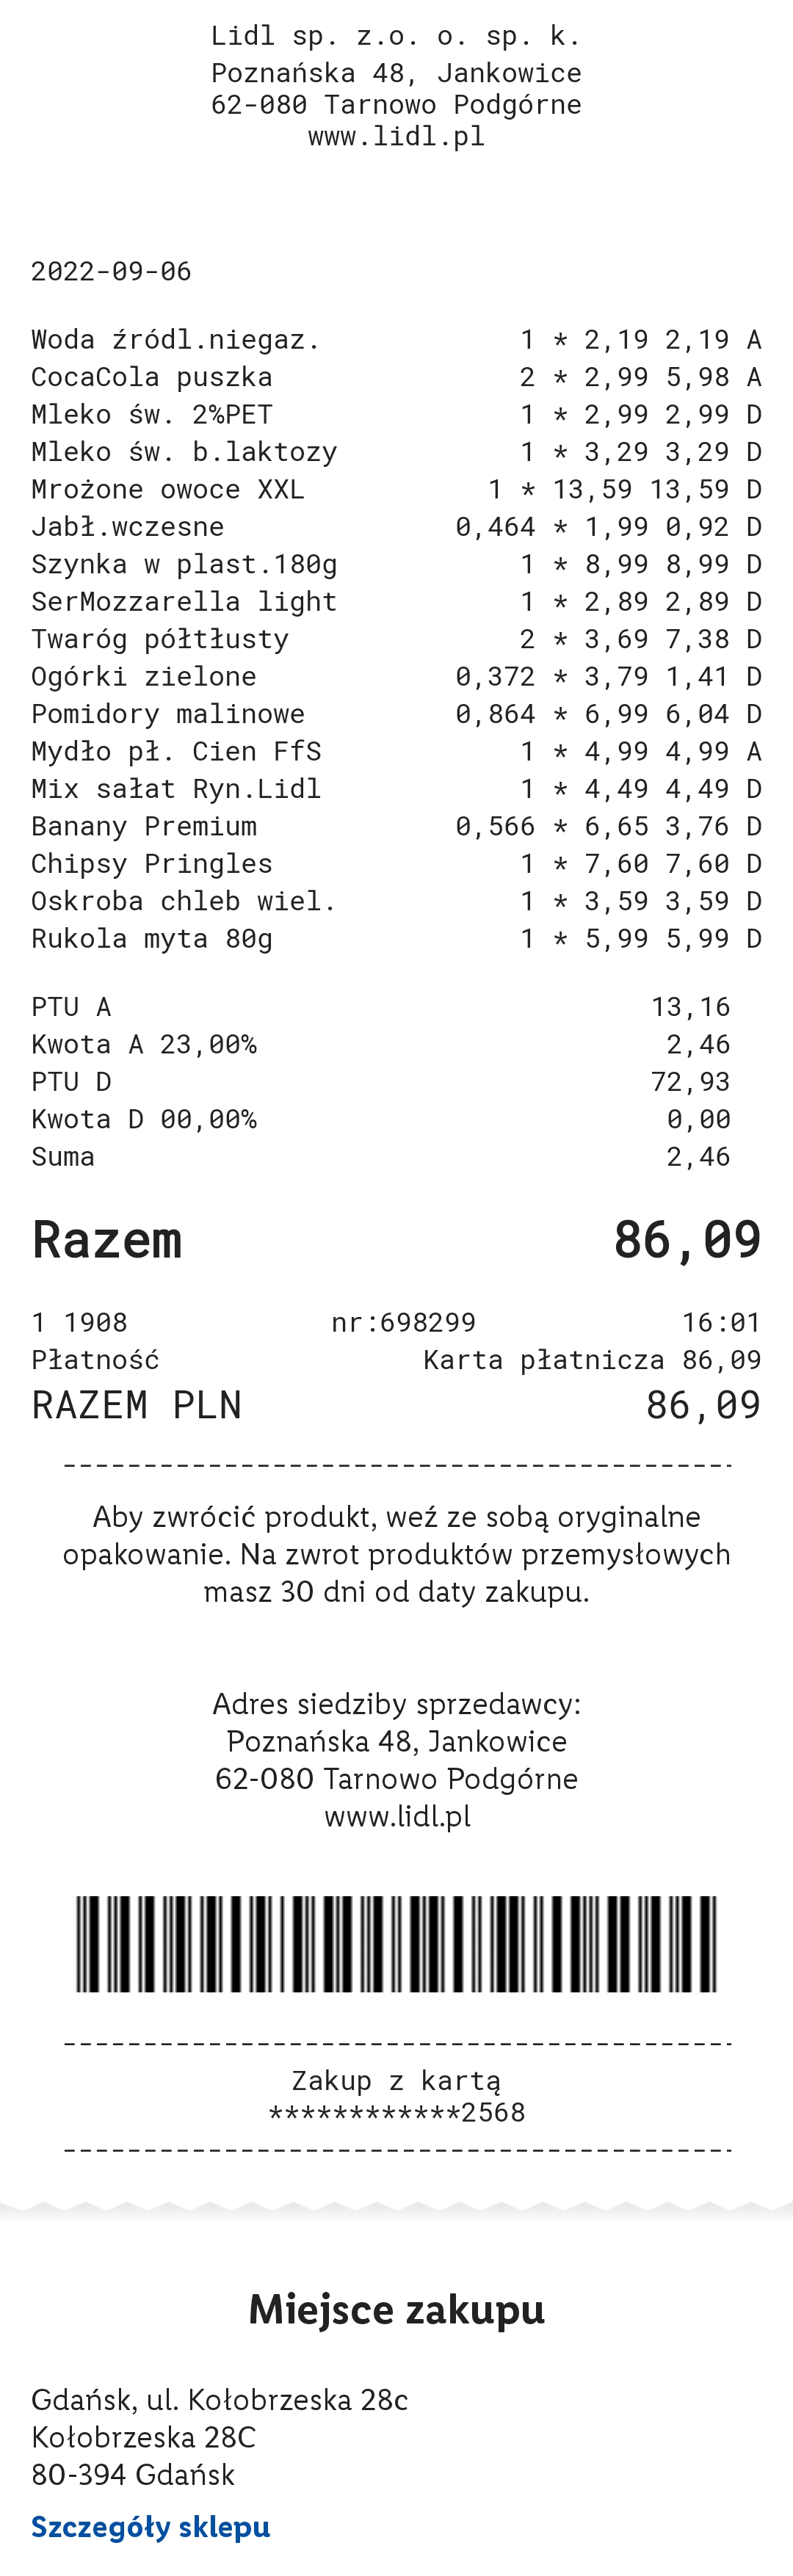

In [61]:
from IPython.display import Image
Image('2022.09.06_24001908120220906698299.jpg.png', width=500, height=1000)


In [89]:
bounds = reader.readtext('2022.09.06_24001908120220906698299.jpg.png')

In [90]:
# assign output to arrays and create then DataFrame 
arr1 = list()
arr2 = list()
arr3 = list()
arr4 = list()
text = list()

for bound in bounds:
  arr1.append(bound[0][0][0])
  arr2.append(bound[0][1][0])
  arr3.append(bound[0][2][0])
  arr4.append(bound[0][3][0])
  text.append(bound[1])

In [91]:
# I don't know what parameters easyocr return. Most probably some coordinates of text what was recognized. But i keep name of parametrs simple :)
df = pd.DataFrame({"Param1":arr1, "Param2":arr2,"Param3":arr3,"Param4":arr4,"Text":text})

In [92]:
df

,Param1,Param2,Param3,Param4,Text
0,279,383,383,279,Lidl
1,394,452,452,394,sp -
2,483,561,561,483,Z . 0 _
3,590,624,624,590,0
4,657,718,718,657,sp _
...,...,...,...,...,...
148,331,755,755,331,Miejsce zakupu
149,37,563,563,37,"Gdańsk, ul. Kołobrzeska 28c"
150,39,357,357,39,Kołobrzeska 28C
151,38,326,326,38,80-394 Gdańsk


## Cleaning

In [93]:
df[:30]

,Param1,Param2,Param3,Param4,Text
0,279,383,383,279,Lidl
1,394,452,452,394,sp -
2,483,561,561,483,Z . 0 _
3,590,624,624,590,0
4,657,718,718,657,sp _
5,745,784,784,745,k
6,284,488,488,284,Poznańska
7,504,562,562,504,48
8,591,798,798,591,Jankowice
9,282,425,425,282,62-080


In [94]:
# Seems like first item starts when Param1 about 40. Most probably is Param1 = "Number of pixels from left side"
first_rows = df[df['Param1'] < 40].index[0]
df1 = df.iloc[first_rows+1:,:]
df1.reset_index(inplace=True)

In [95]:
# when there is a text about taxes - i already not interested in everything below
last_row = df1[df1['Text'] == 'PTU'].index[0]
df1 = df1.iloc[:last_row,:]
df1.reset_index(inplace=True)

In [96]:
# adding to df a column, with Product name
df1['Product'] = ""
df1['Qty'] = ""
df1['Price'] = ""

In [97]:
df1.drop('level_0', axis=1, inplace=True)
df1.drop('index', axis=1, inplace=True)

## Tranform Text column to Product name, Qty of purchased item and Price per item

In [98]:
# Product qty and price starting in the middle of recipt, so it's about 550 pixels. 
trashold_left = 550
def get_values(sliced_df):
    product = str()
    price_qty = str()

    for row in range(len(sliced_df)):
        if sliced_df.iloc[row, 0] < trashold_left:
            # separate product from rest of item line
            product = product + sliced_df.iloc[row, 4]
            product = re.sub(r'[^A-Za-z]', '', product)
        else:
            # the rest of item line. everything but Product
            price_qty = price_qty + sliced_df.iloc[row, 4]
    price_qty = price_qty.replace('A', "").replace('D', "").replace(',', '.').replace(" ", "")

    # qty is right before * sign
    star_point = price_qty.find('*')

    if star_point < 1:
        return 0, 0, 0

    qty = price_qty[:star_point]
    if not qty: qty = 0
    price_qty = price_qty[star_point + 1:]

    price_qty = price_qty
    first_comma = price_qty.find('.')
    price = price_qty[:first_comma + 3]

    # print(float(qty))
    # print(float(price))

    return product, float(qty), float(price)

In [99]:
start_point = 0
for i in range(1, len(df1)):
    if df1.iloc[i, 0] < 40 or i == len(df1) - 1:
        df1.iloc[start_point:i, -3], df1.iloc[start_point:i, -2], df1.iloc[start_point:i, -1] = get_values(
            df1.iloc[start_point:i, :])
        start_point = i

In [100]:
df1.drop(["Param1", "Param2","Param3","Param4"], axis=1, inplace=True)

In [101]:
df1.drop_duplicates(subset=['Product', 'Qty', 'Price', 'Text'], inplace=True)

In [102]:
df1[0:60]

,Text,Product,Qty,Price
0,Woda,Wodardlniegaz,1.0,2.19
1,Źródl.niegaz.,Wodardlniegaz,1.0,2.19
2,1,Wodardlniegaz,1.0,2.19
3,*,Wodardlniegaz,1.0,2.19
4,"2, 19 2, 19",Wodardlniegaz,1.0,2.19
5,A,Wodardlniegaz,1.0,2.19
6,CocaCola puszka,CocaColapuszka,2.0,2.99
7,2,CocaColapuszka,2.0,2.99
8,*,CocaColapuszka,2.0,2.99
9,"2, 99",CocaColapuszka,2.0,2.99


## Final result

In [106]:
df1.drop_duplicates(subset=['Product', 'Qty', 'Price'], inplace=True)
df1.reset_index(inplace=True)
df1

,index,Text,Product,Qty,Price
0,0,Woda,Wodardlniegaz,1.0,2.19
1,6,CocaCola puszka,CocaColapuszka,2.0,2.99
2,12,Mleko,MlekoWPET,1.0,2.99
3,18,Mleko,MlekoWblaktozyMrooneowoceXXLJabwczesne,1.0,3.29
4,38,szynka,szynkaWplastg,1.0,8.99
5,44,SerMozzarella,SerMozzarellalight,1.0,2.89
6,51,Twaróg półtłusty,Twargptusty,2.0,3.69
7,55,Ogórki,Ogrkizielone,0.372,3.79
8,60,Pomidory malinowe,Pomidorymalinowe,0.864,6.99
9,65,Mydło pł-,MydopCienFfs,1.0,4.99


Conclusion: EasyOCR did a good job, but there are still some mistakes presented :


1.   line nr 3, some text was merged
2.   line nr 10, this will happen in all places, where OCR didn't recognized '*' sign. Hence i am not able to separate qty and price. So 0 returned

Mostly it relates to how text is recognized. But it did amazing job with all numbers (and numbers are weak point of Pytesseract)